In [35]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import mysql.connector

import sys
sys.path.insert(0,"/home/apprenant/PycharmProjects/FoodFlix")


In [36]:
#keep the data
df = pd.read_csv("../data/02_intermediate/intermediate.csv", sep=',', low_memory=False)
df.columns

Index(['product_name', 'generic_name', 'brands', 'categories',
       'nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],
      dtype='object')

In [37]:
# je ne garde que les données quantitatives
int_float_df = df.select_dtypes(include=['int64', 'float64'])
int_float_df.columns

Index(['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')

In [67]:
# je divise les ppair plot en 2 pour plus de lisibilité
columns = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g','proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g']


<AxesSubplot:>

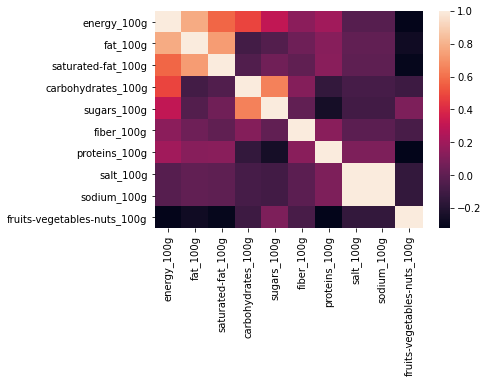

In [68]:
to_heat = int_float_df.loc[:,columns]
sns.heatmap(to_heat.corr())

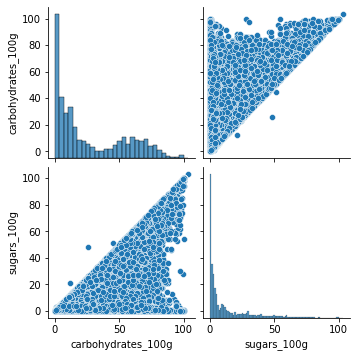

In [60]:
#corrélation entre sugar et glucide
columns3 = ['carbohydrates_100g','sugars_100g']
df_corr3 = int_float_df.loc[:,columns3]
sns.pairplot(df_corr3)
plt.show()

on constate que les glucides sont composés entre autre de sucre, ce qui fait que la teneur en sucre ne peut etre supérieure aux glucides.


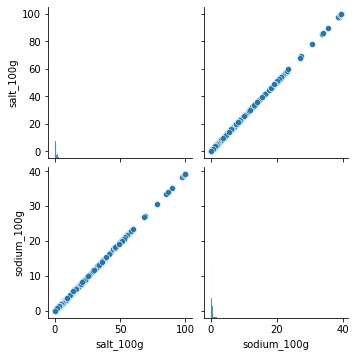

In [64]:
#corrélation entre sel et sodium
columns4 = ['salt_100g','sodium_100g']
df_corr4 = int_float_df.loc[:,columns4]
sns.pairplot(df_corr4)
plt.show()

Le sel est composé à 40% de sodium (notion métier). Cette corrélation est parfaitement visible dans le jeu de donées:pour 100g de sel on a 40g de sodium max.

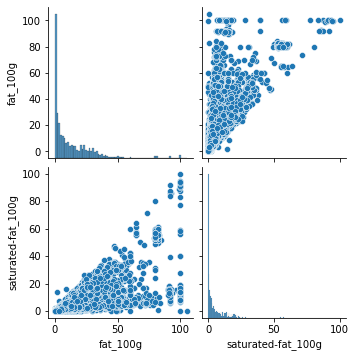

In [61]:
#corrélation entre sturedfat et fat
columns3 = ['fat_100g', 'saturated-fat_100g']
df_corr3 = int_float_df.loc[:,columns3]
sns.pairplot(df_corr3)
plt.show()

on constate que les graisses saturées sont un type de graisse, donc le niveau de graisses saturées ne peut etre supérieur aux graisses.

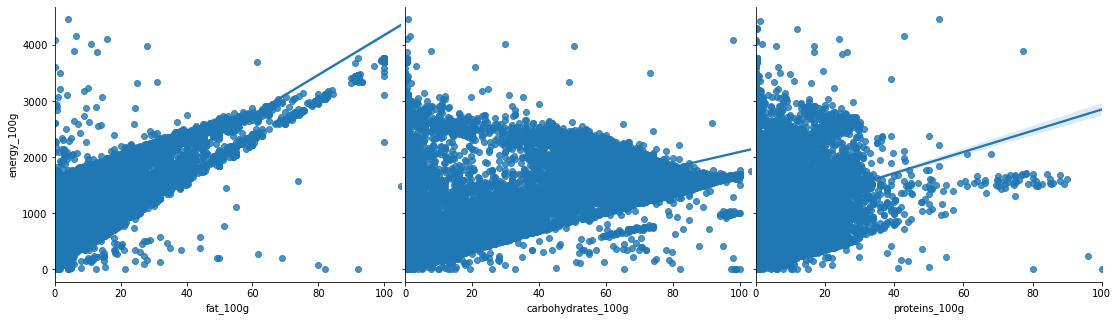

In [62]:

g = sns.PairGrid(int_float_df, y_vars=["energy_100g"], x_vars=['fat_100g', 
                                                   'carbohydrates_100g', 'proteins_100g'], height = 25)
g.map(sns.regplot)
fig=plt.gcf()
fig.set_size_inches(15,4)

# 1. Traitement des Doublons

## 2.1 recherche des doublons

In [42]:
print(df.duplicated().value_counts())
df.shape

False    29424
True        25
dtype: int64


(29449, 17)

## II.2 Traitement des doublons

In [43]:
df.drop_duplicates(keep='last',inplace=True)
print(df[df.duplicated(keep=False)])
df.shape

Empty DataFrame
Columns: [product_name, generic_name, brands, categories, nutrition_grade_fr, energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, fruits-vegetables-nuts_100g, nutrition-score-fr_100g, nutrition-score-uk_100g]
Index: []


(29424, 17)

# 2. Traitement des valeurs manquantes

In [44]:
#recherche des valeurs manquantes:

print(df.isna().sum())
print(df.shape)

product_name                       0
generic_name                   18642
brands                           314
categories                      9381
nutrition_grade_fr              5016
energy_100g                     4131
fat_100g                        8449
saturated-fat_100g              4637
carbohydrates_100g              8571
sugars_100g                     4625
fiber_100g                     12591
proteins_100g                   4186
salt_100g                       4606
sodium_100g                     4606
fruits-vegetables-nuts_100g    28577
nutrition-score-fr_100g         5016
nutrition-score-uk_100g         5016
dtype: int64
(29424, 17)


comme il s'agit ici de calculer un score, je remplace toutes les valeurs Nan par zéro.

In [45]:
df = df.fillna(0)

In [46]:
print(df.isna().sum())
print(df.shape)

product_name                   0
generic_name                   0
brands                         0
categories                     0
nutrition_grade_fr             0
energy_100g                    0
fat_100g                       0
saturated-fat_100g             0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
sodium_100g                    0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
nutrition-score-uk_100g        0
dtype: int64
(29424, 17)


on constate que les Nan ont bien été modifiées.

# 3.Consistance, reformatage et valeurs abbérantes.

## 3.1 Evaluer la consistance des variables de type caractère.

#### Afficher l'ensemble des valeurs uniques

In [47]:
df["product_name"].value_counts()

Huile d'olive vierge extra          20
Orange                              18
Lait demi-écrémé                    17
Spaghetti                           17
Mayonnaise                          17
                                    ..
Tartinade de Thon                    1
3 Oeufs avec surprise                1
Zéro café Peach on the beach         1
Jambon Cuit Superieur 4 Tranches     1
Coulommiers (23% MG)                 1
Name: product_name, Length: 26339, dtype: int64

pour les produits sur-représentés il convient de vérifier quelle valeur est la bonne

Il y a 17 occurence de mayonnaise, je vais donc les remplacer par une seule qui aura pour valeur la moyenne des 22 autres produits.

In [48]:

df2 = df.groupby('product_name').agg({'energy_100g':'mean',
                                     'sugars_100g':'mean',
                                     'fiber_100g':'mean',
                                     'proteins_100g':'mean',
                                     'sodium_100g':'mean',
                                     'saturated-fat_100g':'mean',
                                     'nutrition-score-fr_100g':'mean',
                                     'nutrition_grade_fr':'first'
                                     })

#check
df2


,energy_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition_grade_fr
product_name,,,,,,,,
Biscuit Tablette Chocolat au Lait bio,2198.0,35.2,2.3,7.00,0.208661,13.30,22.0,e
Bière,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0
Boulettes à la Marocaine et légumes,393.0,2.0,0.5,5.10,0.157480,1.10,0.0,b
Calamars à la Romaine surgelés,707.0,1.7,1.2,7.50,0.490000,1.40,3.0,c
Edition Limitée Mandarine Kiwi Citron,226.0,11.6,1.2,0.50,0.000000,0.00,5.0,c
...,...,...,...,...,...,...,...,...
寿司米,1504.0,0.2,1.0,6.70,0.005120,0.10,-1.0,a
日の出 - 新味料 - みりん風調味料 - Sauce pour cuisine japonaise,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0
素牛肉乾,1490.0,17.9,0.0,7.14,0.893000,3.57,19.0,e


## 3.2 Evaluer la consistance des variables de type numérique

#### Afficher la distribution d'une variable numérique

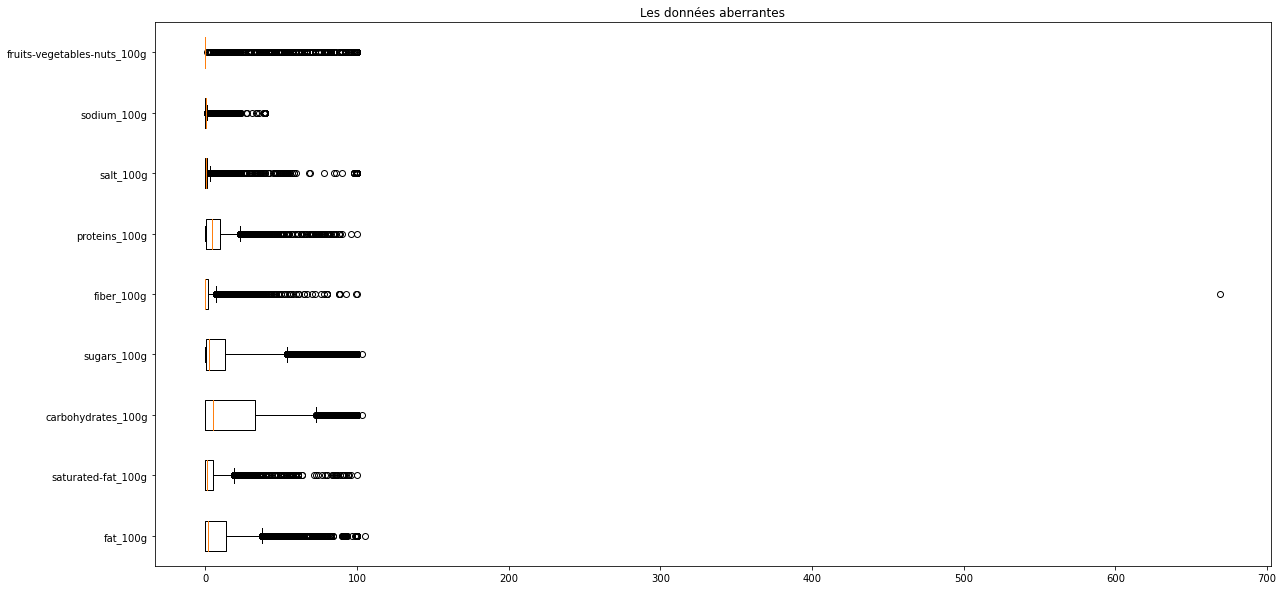

In [51]:
data = [ df['fat_100g'], df['saturated-fat_100g'],df['carbohydrates_100g'],df['sugars_100g'],df['fiber_100g'],df['proteins_100g'],df['salt_100g'],df['sodium_100g'],df['fruits-vegetables-nuts_100g']]
plt.figure(figsize = (20,10))
ax = plt.boxplot(data, whis=[5,95], vert=False)


plt.title('Les données aberrantes')
plt.yticks([1, 2, 3,4,5,6,7,8,9], ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g' ])


plt.show()   

il s'agit de valeurs quantitatif pour 100g de produit ces valeurs ne peuvent donc ni etre négatives ni supérieures à 100

In [52]:
columns=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'fruits-vegetables-nuts_100g']

for col in columns:
    df.loc[df[col]> 100, col] = 0
    

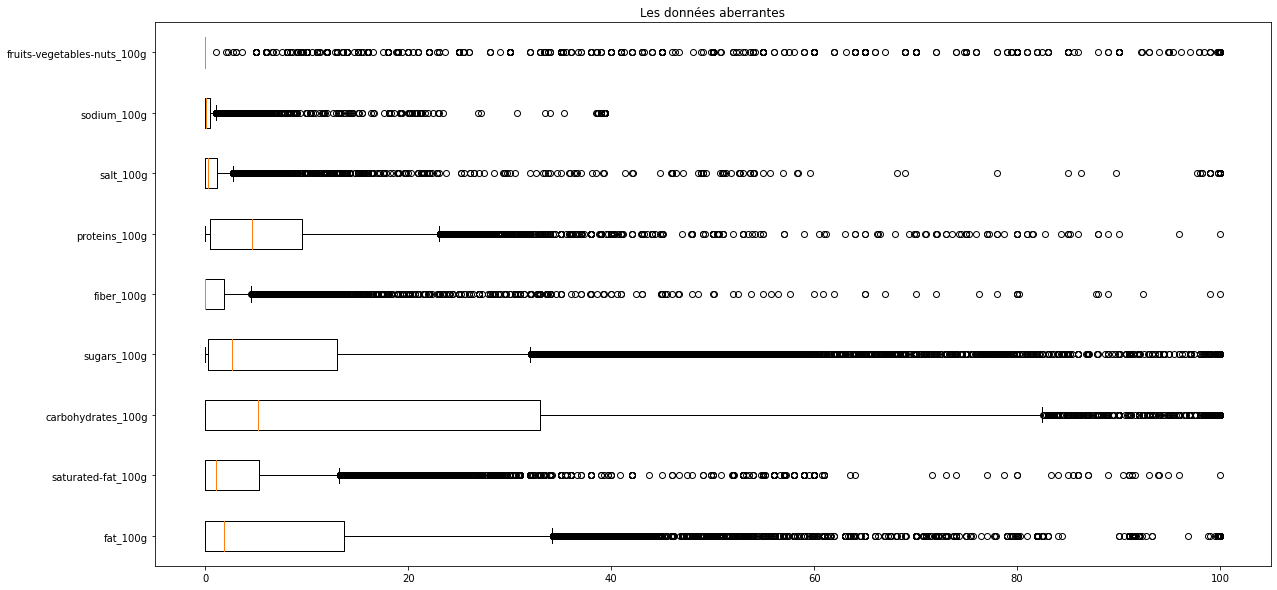

In [53]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(data, vert=False)


plt.title('Les données aberrantes')
plt.yticks([1, 2, 3,4,5,6,7,8,9], ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g' ])

plt.show()   

#### Traiter les valeurs impossibles

l'énergie d'un aliment ne peut pas être supérieure à 4000KJ (notion métier)

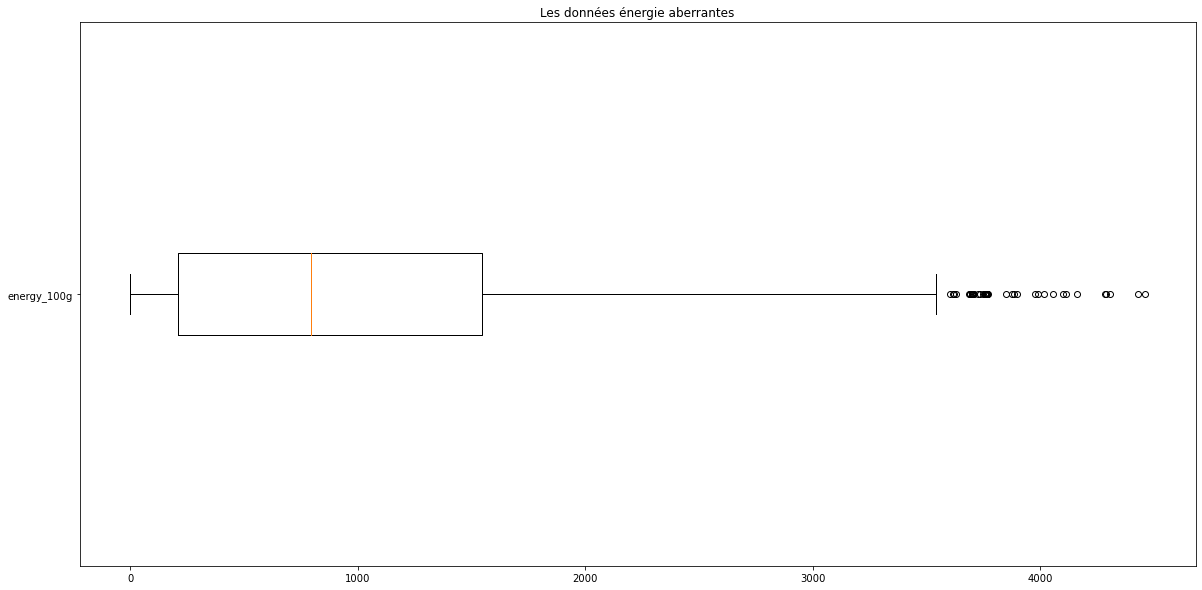

In [54]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(df['energy_100g'], vert=False)

plt.title('Les données énergie aberrantes')
plt.yticks([1], ['energy_100g' ])

plt.show()   

In [55]:
df = df[df['energy_100g']<4000]

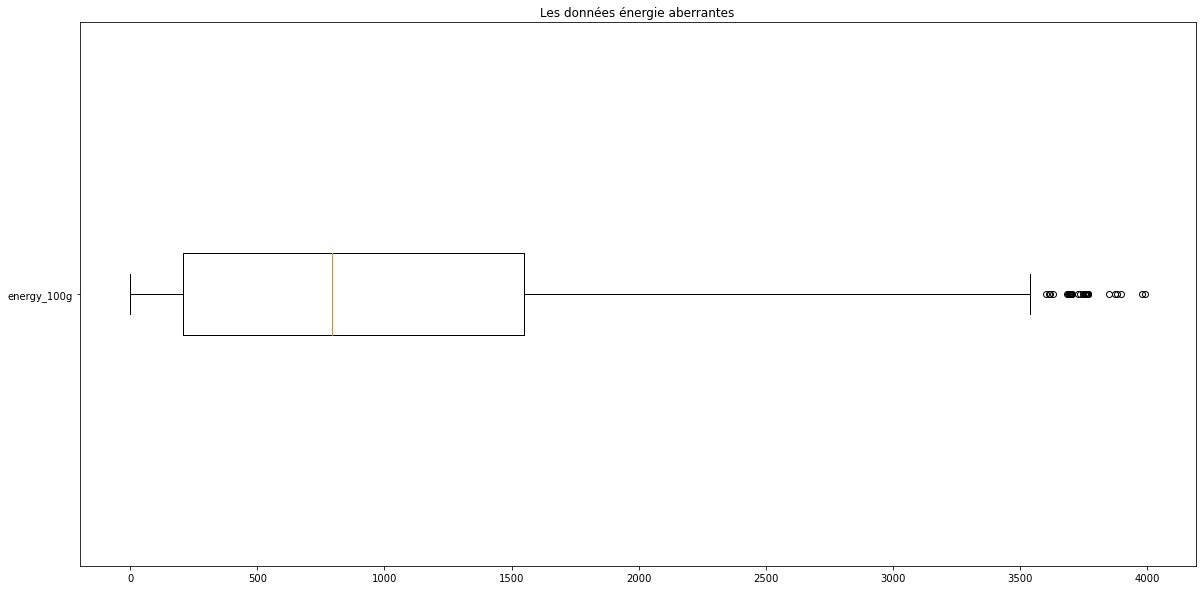

In [56]:
plt.figure(figsize = (20,10))
ax = plt.boxplot(df['energy_100g'], vert=False)

plt.title('Les données énergie aberrantes')
plt.yticks([1], ['energy_100g' ])

plt.show()   

# sauvegarde du jeu de données nettoyées

In [57]:
df.to_csv("../data/02_intermediate/final.csv")